In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import timm, torch, argparse, yaml, pickle, csv, AutoAugment
from softdataset import TripletImageDataset
from original_dataset import OriginalImageDataset
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import DataLoader
from collections import OrderedDict as OD
from tqdm import tqdm
from torchvision import transforms
import torchvision.transforms.functional as FF
from torch.nn import functional as F
from torch.nn import *
from torch import nn
from PIL import Image
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from collections import namedtuple as NT

/home/ubuntu/anaconda3/envs/retrieval/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_dl(path, bs, random = True, trainval_json="", trainval="test"):        
    
    ''' 
    Get path to the images and returns dataloader with transformations applied
    Arguments:

    path - path to the dir with images;
    bs - batch_size;
    random - if False loads train test split json file else randomly mix dataset.      

    '''
    
    transformations = {}   
    
    angles=[-30, -15, 0, 15, 30] # rotation 각도, 이중 하나의 각도로 돌아감 [-30, -15, 0, 15, 30]
    distortion_scale = 0.5 # distortion 각도 (0.5)
    p = 0.5 # distortion이 적용될 확률 (0.5)
    fill = [0,0,0] # distortion 후 채워지는 배경색
    fill_sketch = [255,255,255] # distortion 후 채워지는 배경색

    transformations['qry'] = transforms.Compose([
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomRotation(90, fill = fill),
                            # transforms.ColorJitter([0.3, 1]),
                            # transforms.GaussianBlur(9, (0.5, 3.0)),
                            transforms.ToTensor(),
                                                  ])

    transformations['pos'] = transforms.Compose([
        transforms.RandomRotation(90, fill = fill_sketch),
        transforms.RandomPerspective(distortion_scale = distortion_scale, p = p, fill = fill_sketch),
        transforms.ToTensor(),
    ])  
    transformations['neg'] = transforms.Compose([
        transforms.RandomRotation(90, fill = fill_sketch),
        transforms.RandomPerspective(distortion_scale = distortion_scale, p = p, fill = fill_sketch),
        transforms.ToTensor(),
    ])
    
    out_path = "data/test_dataset_svg_1122_3_org.json"    
    
    dataset = TripletImageDataset(data_dir = path, transform_dic=transformations, random=True, trainval_json=out_path, trainval=trainval, load_images=True)  
    all_dl = DataLoader(dataset, batch_size=bs, shuffle=False, drop_last=False, num_workers=8)
    
    num_classes = dataset.get_prod_length()
    print(f"The dataset has {num_classes} classes")
    
    print(f"Number of test samples: {len(dataset)}")
    
    test_dl = DataLoader(dataset, batch_size=bs, shuffle=True, drop_last=True, num_workers=8)

    return num_classes, dataset, test_dl


def load_checkpoint(checkpoint_path, model_name, pretrained=False, num_classes=None, from_pytorch_lightning=True, init_conv=False):

        ''' 
        
        Loads checkpoint_path from the given path to the directory with the trained model.
        Arguments:
        
        checkpoint_path - path to the dir with the trained model;
        model_name - name of the trained model (name is the same as in the timm library);
        pretrained - creates a model with pretrained weights on ImageNet;
        init_conv - initial convolution layer, default is True;
        from_pytorch_lightning - used to load the trained model from pytorch_lightning.
        If True the model is trained using pytorch_lightning, else with a regular torch library;
        Default is False
        
        '''        
        assert num_classes is not None, "Please set the number of classes in the dataset!"
        
        if from_pytorch_lightning: # for a pytorch_lightning model
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
            # print(checkpoint['state_dict'].keys())
            if init_conv:                
                base_model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
                conv_layer = torch.nn.Sequential(torch.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1),padding=(1,1), bias=False), 
                 # nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2),padding=(1,1), bias=False), 
                 # nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1)),
                 torch.nn.SiLU(inplace=True))
                model = torch.nn.Sequential(conv_layer, base_model) 
                print("Model with init_conv True")
            else:
                model = timm.create_model(model_name, num_classes=num_classes)
                print("Model with init_conv False")

            # create new OrderedDict that does not contain `model.` (for the checkpoint from the pytorch_lightning)
            new_state_dict = OrderedDict()
            for k, v in checkpoint['state_dict'].items():
                name = k.replace("model.", "") # remove `model.`
                new_state_dict[name] = v
            # load params
            model.load_state_dict(new_state_dict, strict=True)
            print(f"Model {model_name} trained using pytorch lightning checkpoint is successfully loaded!")

        else: # for a regular torch model  
            if pretrained:
                model = timm.create_model(model_name, num_classes=num_classes)
                print(f"Model {model_name} with pretrained weights is successfully loaded!")
            else:
                model = timm.create_model("rexnet_150")
                state_dict = torch.load(checkpoint_path)
                model.load_state_dict(state_dict['state_dict'])
                num_features = model.head.fc.in_features
                model.classifier = Linear(num_features, num_classes) if num_classes > 0 else Identity() 
                print(f"Model {model_name} with the best weights is successfully loaded!")            

        return model
    
def inference(model, dataloader, device):

        ''' 
        
        Inference using trained model and test dataloader.
        Arguments:
        
        model - trained model from the checkpoint (see load_checkpoint function);
        dataloader - test dataloader (see get_dl function);
        device - gpu device.
        
        '''   
        
        loss_module = torch.nn.CosineEmbeddingLoss(margin=0.5).to('cuda')
        pool = nn.AvgPool2d((7,7))
        ims, poss, pos_scores, neg_scores, fms_ims_all, fms_poss_all, fms_negs_all, losses, classes_all, pred_lbls_all = [], [], [], [], [], [], [], [], [], []
        cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
        model.to(device)
        model.eval()
        
        def forward(inp):
            def dict_to_namedtuple(dic):
                return NT('GenericDict', dic.keys())(**dic)

            dic = {}                        
            fm = model.forward_features(inp)
            pool = nn.AvgPool2d((7,7))
            lbl = model.forward_head(fm)
            dic["feature_map"] = torch.reshape(pool(fm), (-1, fm.shape[1]))
            dic["class_pred"] = lbl
            out = dict_to_namedtuple(dic)
            return out
        
        model.forward = forward
        print("Obtaining embeddings...")
        
        for i, batch_all in tqdm(enumerate(dataloader)):
            ims_all, poss_all, negs_all, clss_all, regs_all = batch_all['qry'], batch_all['pos'][0], batch_all['neg'][0], batch_all['cat_idx'], batch_all['prod_idx']
            ims.extend(ims_all)
            poss.extend(poss_all)
            classes_all.extend(regs_all.to(device)) 
            
            with torch.no_grad():
                # with torch.cuda.amp.autocast():
                out_ims_all = model(ims_all.to(device))            
                fm_ims_all, lbl_ims_all = out_ims_all[0], out_ims_all[1] # get feature maps [0] and predicted labels [1]
                vals, inds = torch.topk(lbl_ims_all, k=3)
                out_poss_all = model(poss_all.to(device))
                fm_poss_all, lbl_poss_all = out_poss_all[0], out_poss_all[1] # get feature maps [0] and predicted labels [1]
                out_negs_all = model(negs_all.to(device))
                fm_negs_all, lbl_negs_all = out_negs_all[0], out_negs_all[1] # get feature maps [0] and predicted labels [1]
                fms_ims_all.extend(fm_ims_all) #bs, fm 
                fms_poss_all.extend(fm_poss_all)
                fms_negs_all.extend(fm_negs_all)
                pred_lbls_all.extend(inds)
        print("Embeddings are obtained!")        
        print("Calculating metrics...")
        top1 = 0 
        top3 = 0
        fms_ims_all = torch.stack(fms_ims_all) 
        fms_poss_all = torch.stack(fms_poss_all)
        fms_negs_all = torch.stack(fms_negs_all)        
        ims = torch.stack(ims)
        poss = torch.stack(poss)        
        pred_lbls_all = torch.stack(pred_lbls_all)   
        classes_all = torch.stack(classes_all)         
            
        for idx, fm in enumerate(fms_ims_all):
            score = cos(fm.unsqueeze(0), fms_poss_all) #(len(dl))
            pos_score = cos(fm.unsqueeze(0), fms_poss_all[idx].unsqueeze(0)) #(len(dl))
            pos_scores.append(pos_score.item())
            
            score_val, score_inds = torch.topk(score, k=3)  
            if classes_all[idx] in classes_all[score_inds]:
                top3+=1
            if classes_all[idx] in classes_all[score_inds[0]]:
                top1+=1    
            
        return OD([('loss', np.mean(losses)), ('top1', top1/len(fms_ims_all)), ('top3', top3/len(fms_ims_all)), 
                   ('scores', torch.mean(torch.FloatTensor(pos_scores))), ('fms_ims_all', fms_ims_all), ('classes_all', classes_all), 
                   ('fms_poss_all', fms_poss_all), ('ims', ims), ('poss', poss), ('fms_negs_all', fms_negs_all)])

In [3]:
ims_path = "/home/ubuntu/workspace/dataset/test_dataset_svg/test_dataset_svg_1122_3_org"
bs=128
device='cuda:1'
num_classes, test_ds, test_dl = get_dl(path=ims_path, bs=bs, trainval='test')
checkpoint_path = "/home/ubuntu/workspace/bekhzod/triplet-loss-pytorch/pytorch_lightning/saved_models/rexnet_150_Adam_0.001/Test-Training/9114xz5w/checkpoints/epoch=29-val_loss=2.85-cos_sims=0.54-val_top1=0.73.ckpt" #change checkpoint
m = load_checkpoint(checkpoint_path, num_classes=num_classes, model_name='rexnet_150')
results = inference(m, test_dl, device)
results['top3'], results['top1'], results['scores']

The dataset has 178 classes
Number of test samples: 255
Model with init_conv False
Model rexnet_150 trained using pytorch lightning checkpoint is successfully loaded!
Obtaining embeddings...


1it [00:05,  5.19s/it]
/home/ubuntu/anaconda3/envs/retrieval/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/envs/retrieval/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Embeddings are obtained!
Calculating metrics...


(0.8984375, 0.6875, tensor(0.5392))


Input Image


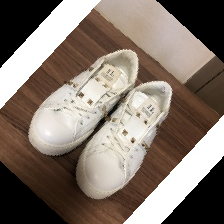


Positive Image



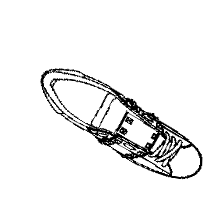


Predicted Images



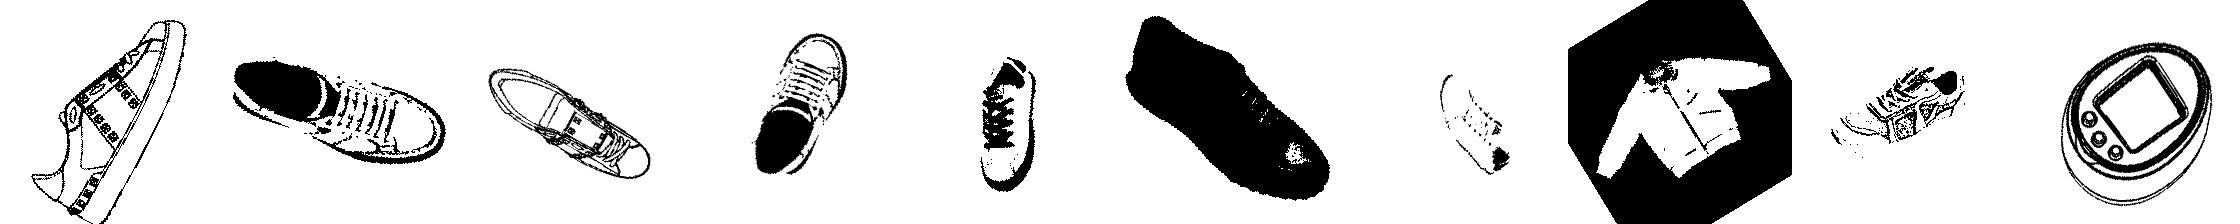

top3: True, top1: True, sim_score: 0.512092113494873

Input Image


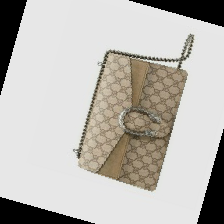


Positive Image



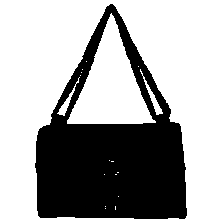


Predicted Images



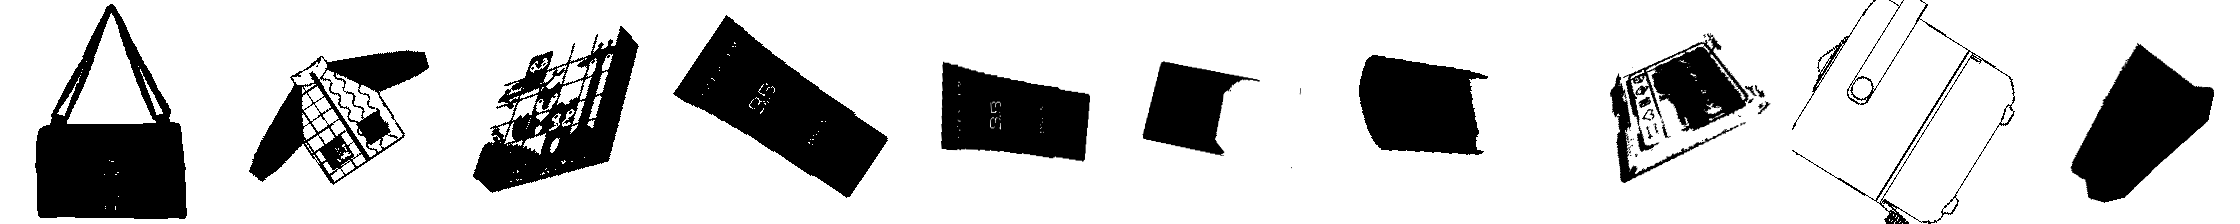

top3: True, top1: True, sim_score: 0.5397993326187134

Input Image


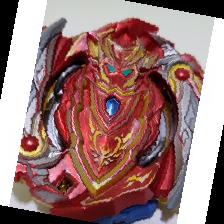


Positive Image



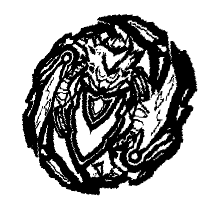


Predicted Images



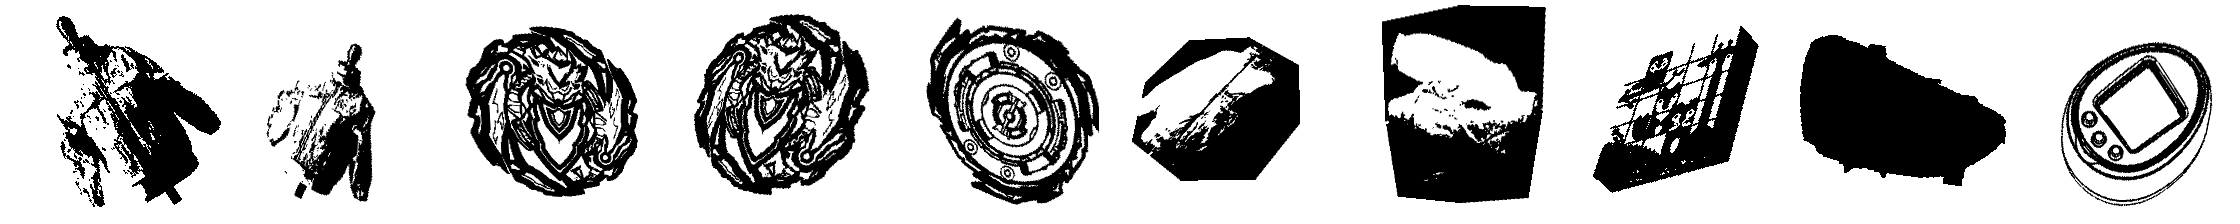

top3: True, top1: False, sim_score: 0.6077156662940979

Input Image


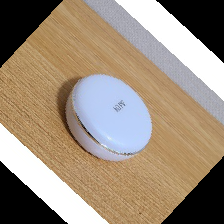


Positive Image



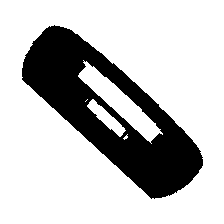


Predicted Images



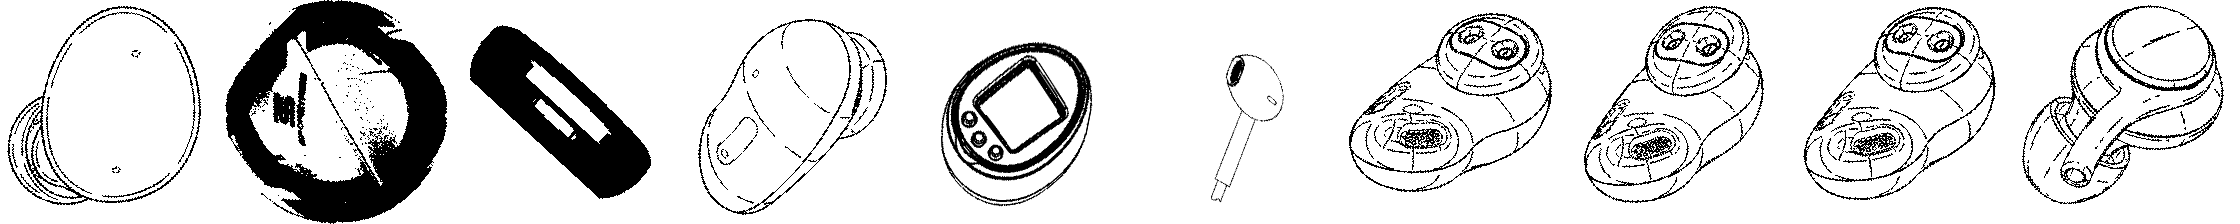

top3: True, top1: False, sim_score: 0.4796789884567261

Input Image


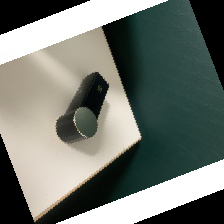


Positive Image



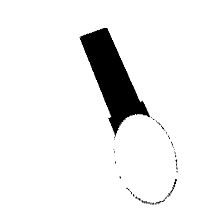


Predicted Images



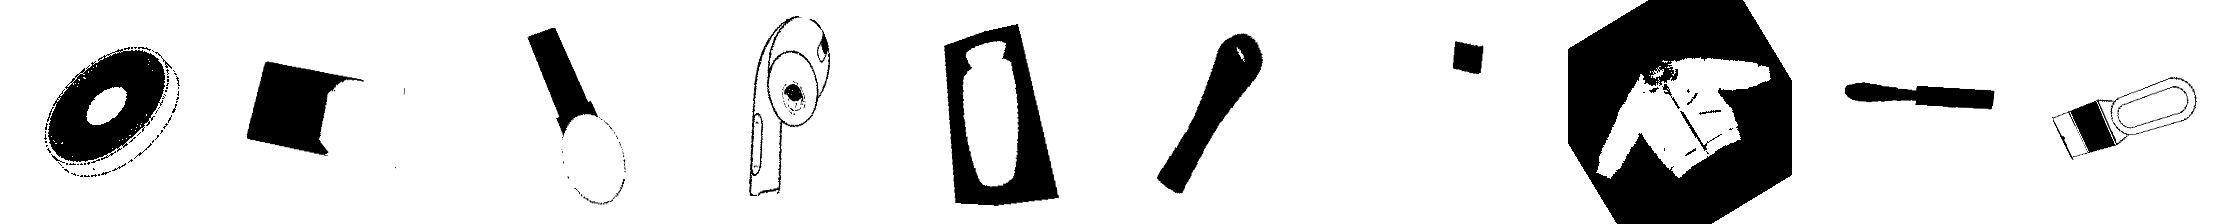

top3: True, top1: False, sim_score: 0.3480783700942993

Input Image


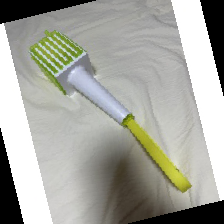


Positive Image



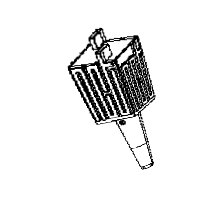


Predicted Images



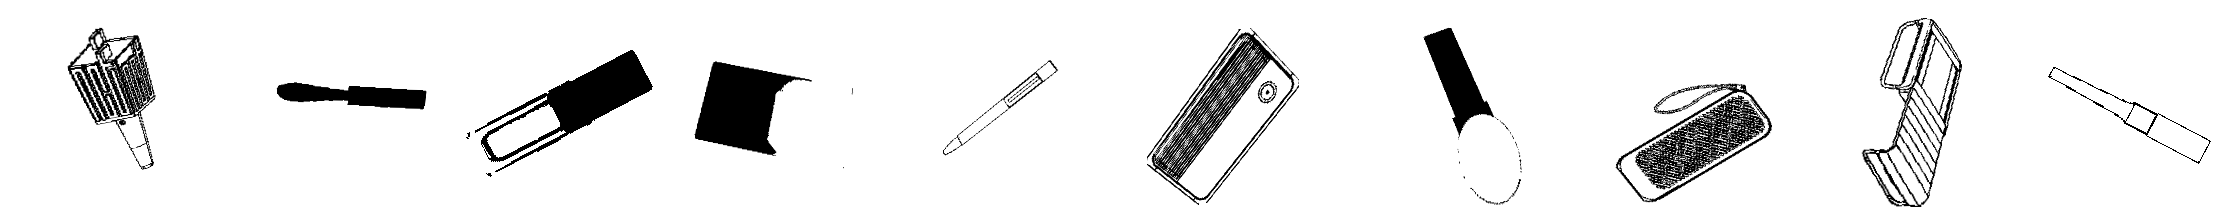

top3: True, top1: True, sim_score: 0.42879152297973633

Input Image


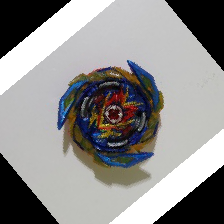


Positive Image



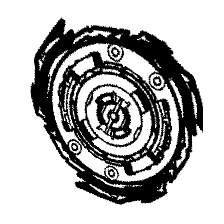


Predicted Images



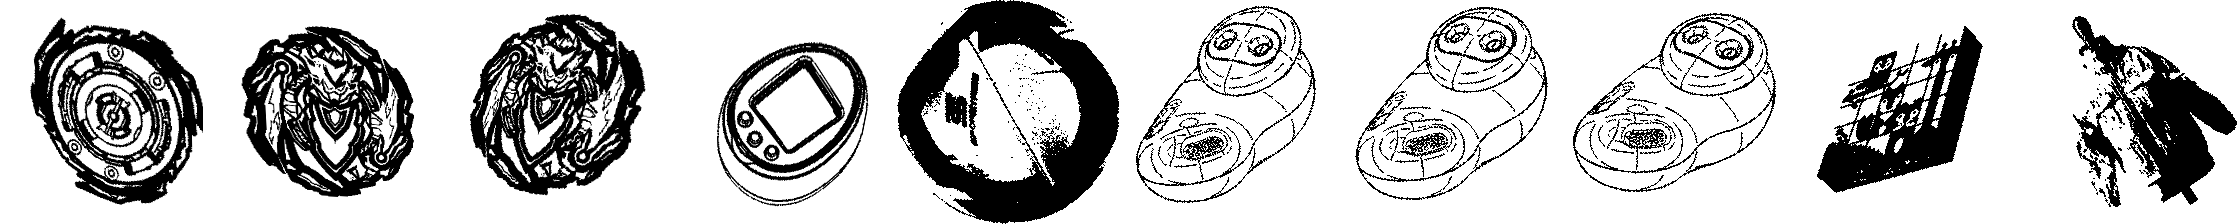

top3: True, top1: True, sim_score: 0.6816514134407043

Input Image


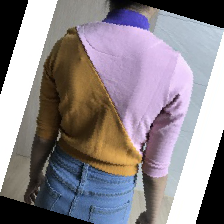


Positive Image



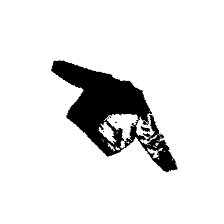


Predicted Images



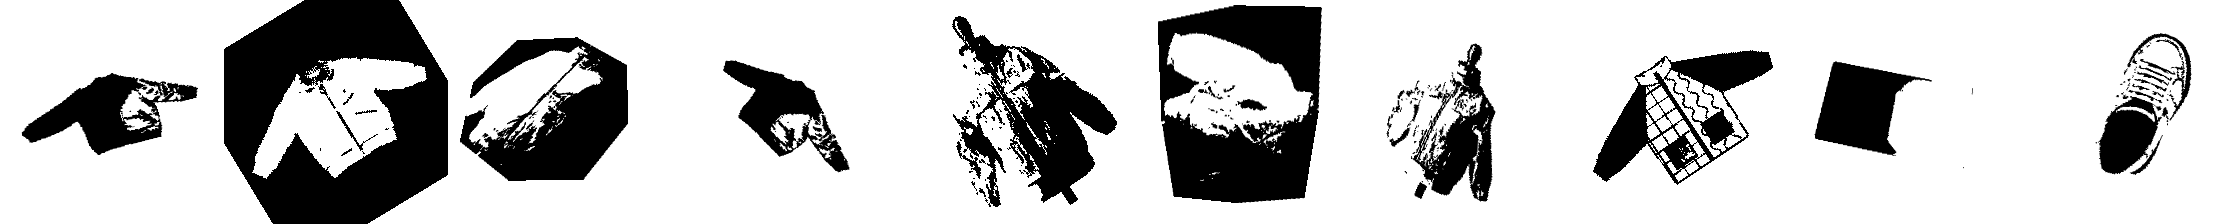

top3: True, top1: True, sim_score: 0.6727622151374817

Input Image


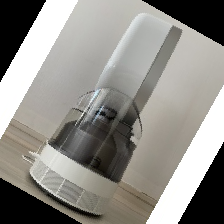


Positive Image



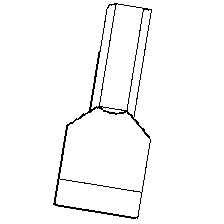


Predicted Images



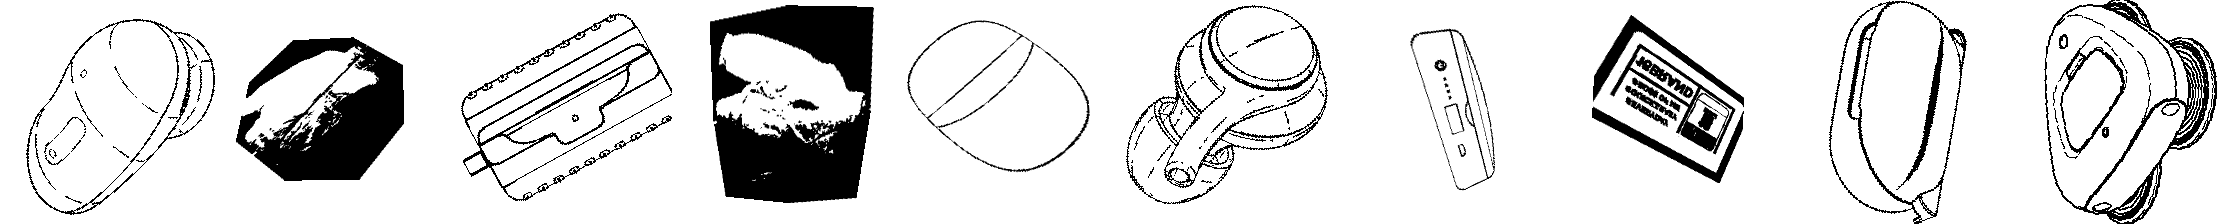

top3: False, top1: False, sim_score: 0.3760446012020111

Input Image


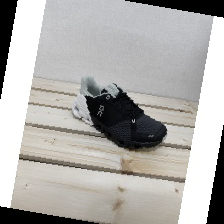


Positive Image



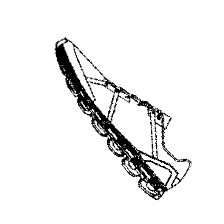


Predicted Images



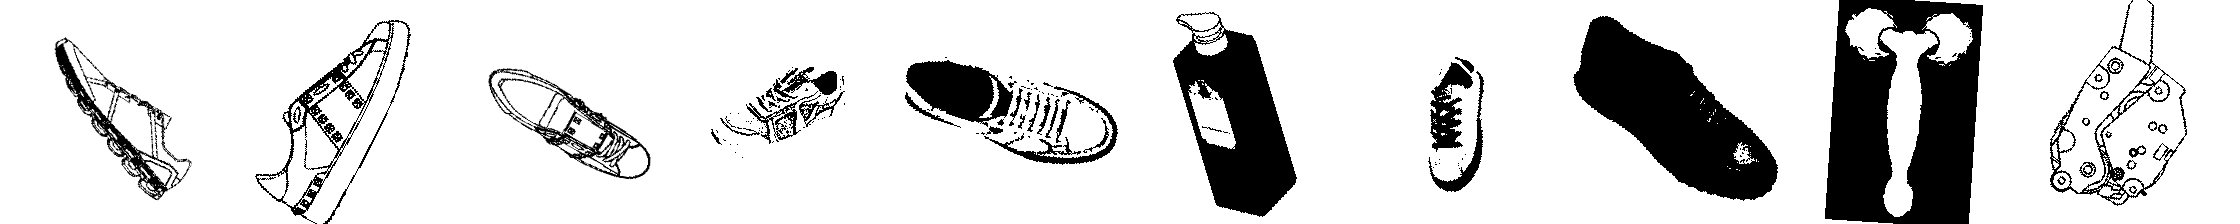

top3: True, top1: True, sim_score: 0.5375643968582153

Input Image


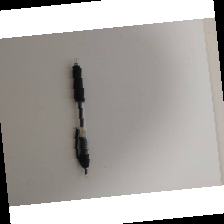


Positive Image



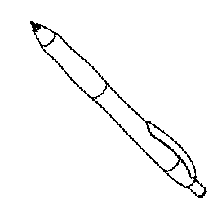


Predicted Images



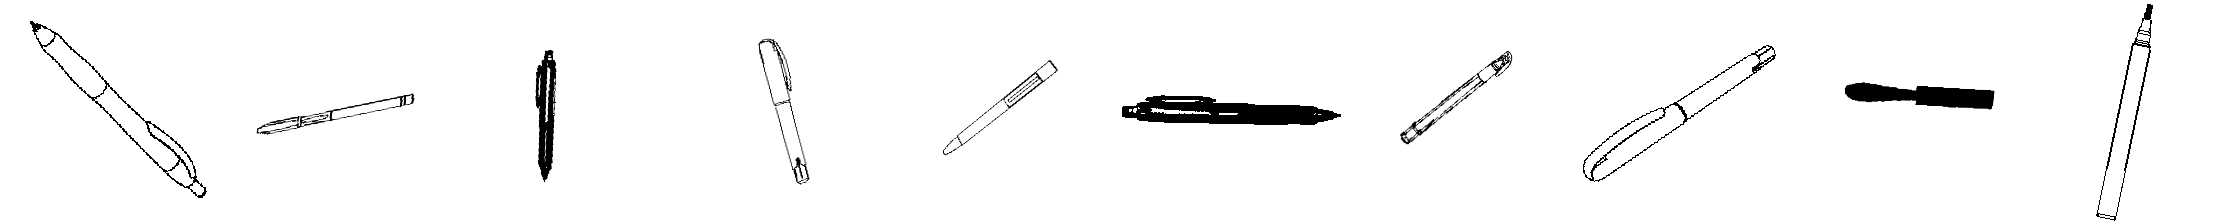

top3: True, top1: True, sim_score: 0.6099922060966492

Input Image


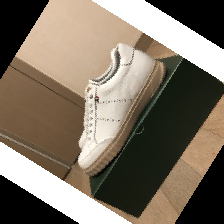


Positive Image



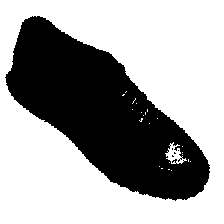


Predicted Images



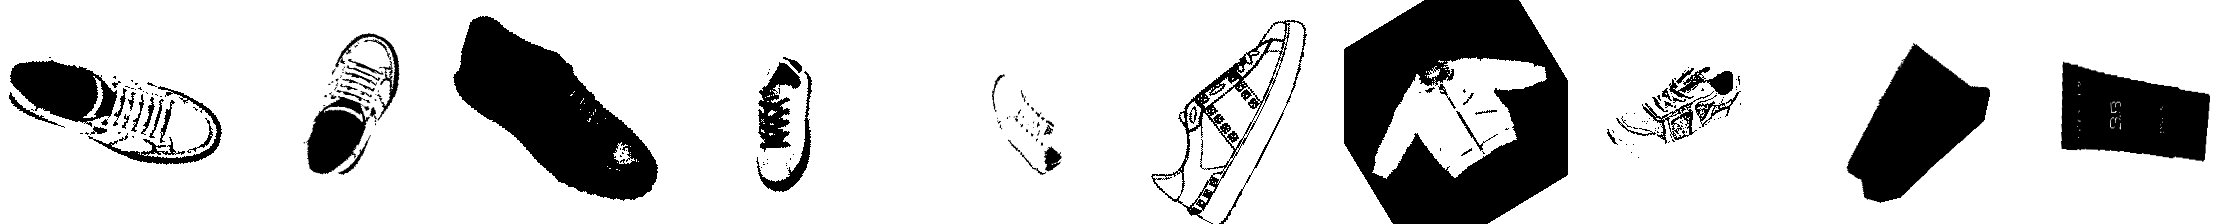

top3: True, top1: True, sim_score: 0.7090927362442017

Input Image


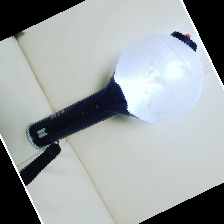


Positive Image



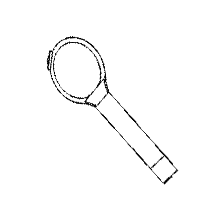


Predicted Images



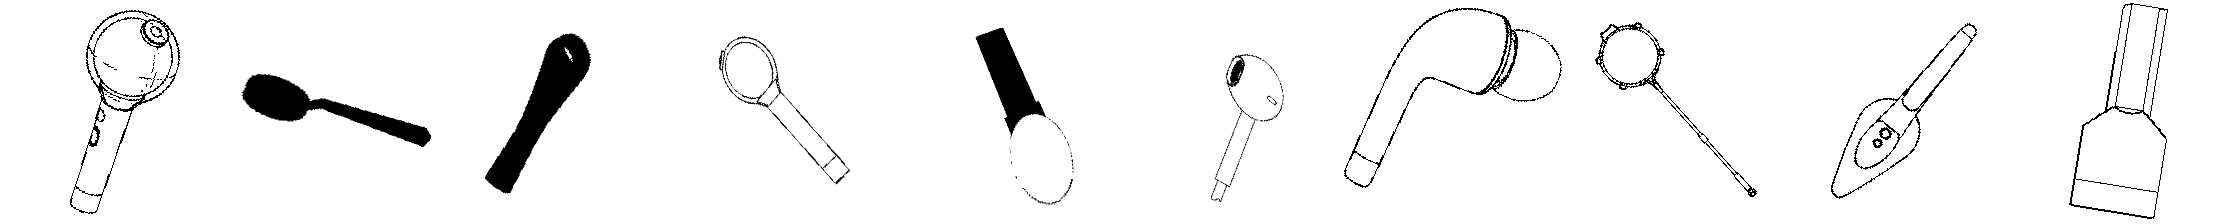

top3: True, top1: True, sim_score: 0.5816824436187744

Input Image


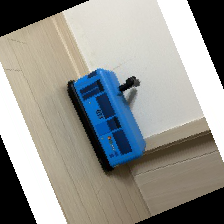


Positive Image



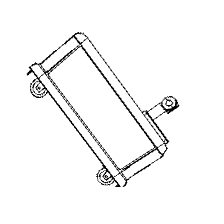


Predicted Images



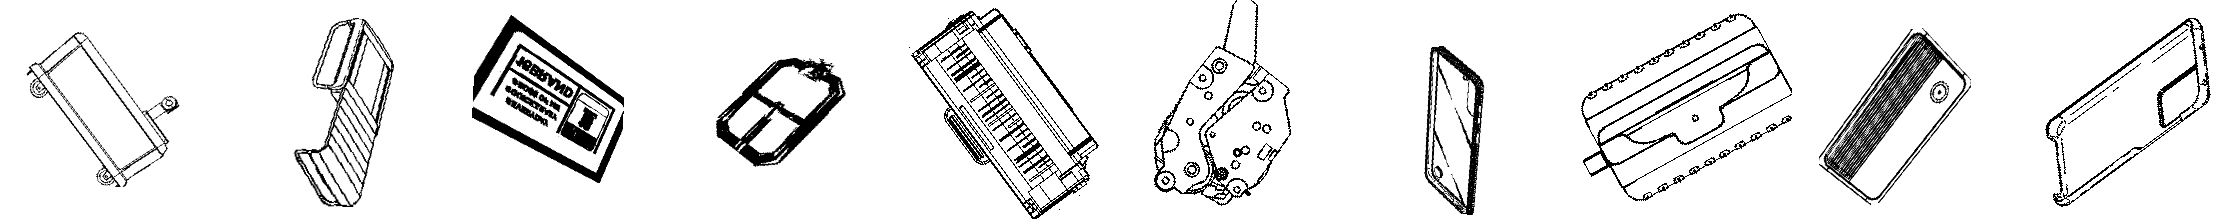

top3: True, top1: True, sim_score: 0.6599791049957275

Input Image


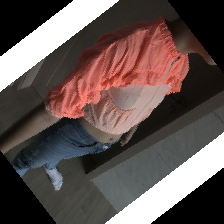


Positive Image



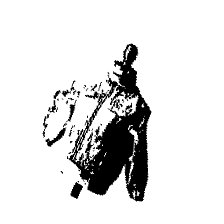


Predicted Images



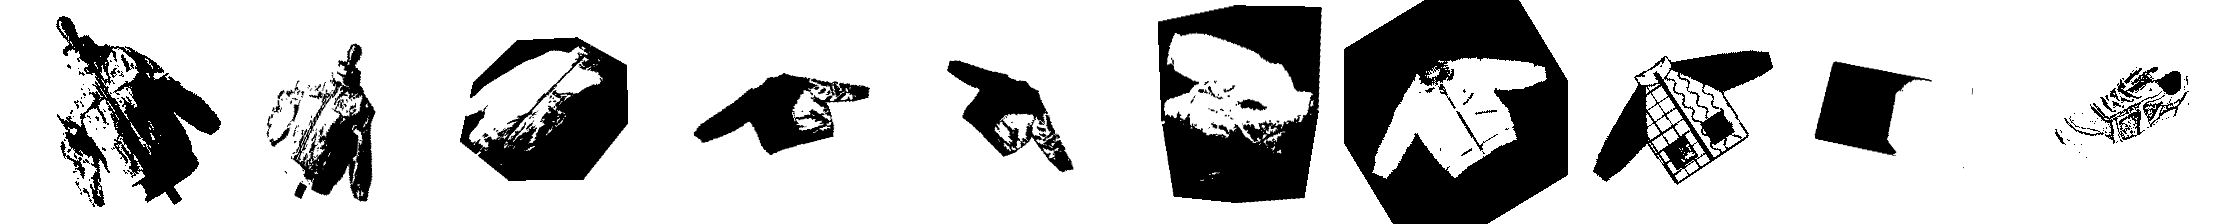

top3: True, top1: True, sim_score: 0.6895730495452881

Input Image


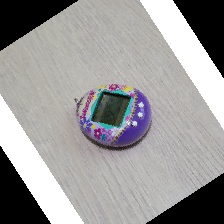


Positive Image



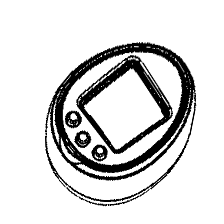


Predicted Images



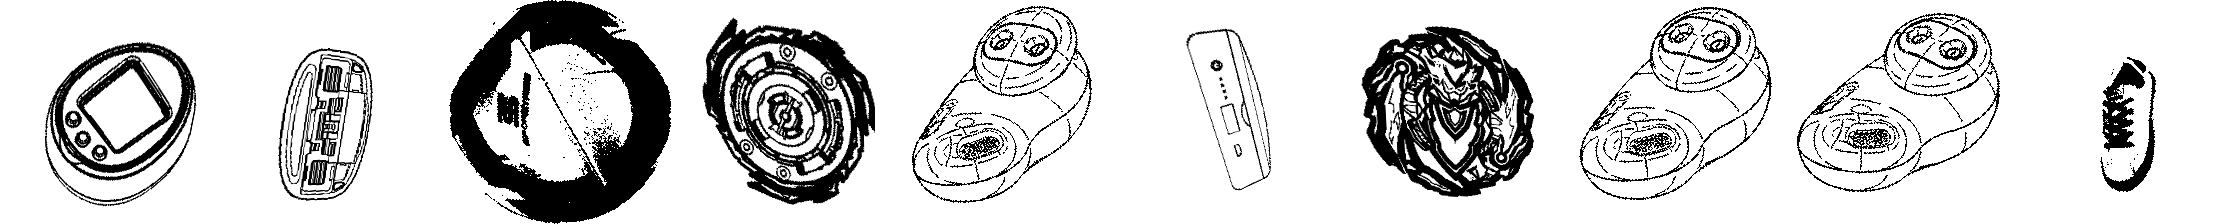

top3: True, top1: True, sim_score: 0.6962006092071533

Input Image


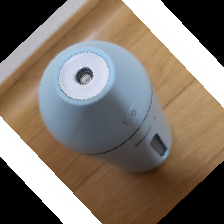


Positive Image



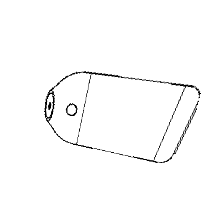


Predicted Images



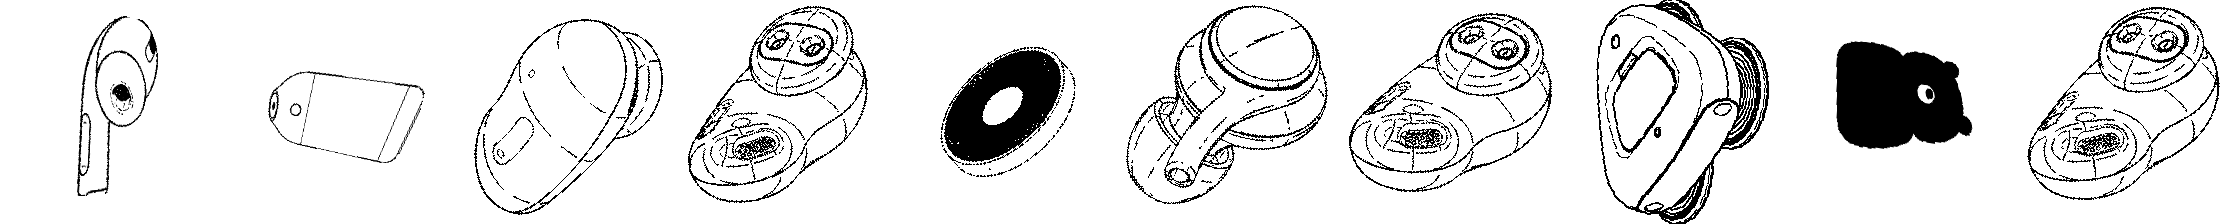

top3: True, top1: False, sim_score: 0.4759887456893921

Input Image


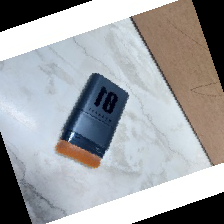


Positive Image



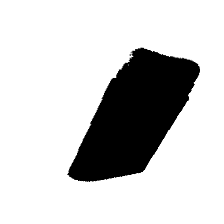


Predicted Images



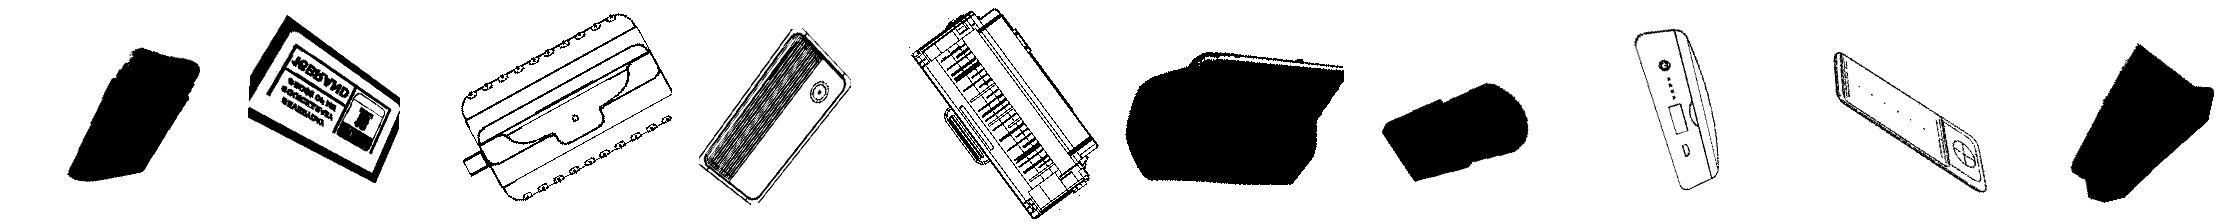

top3: True, top1: True, sim_score: 0.47176745533943176

Input Image


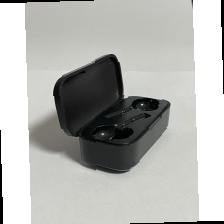


Positive Image



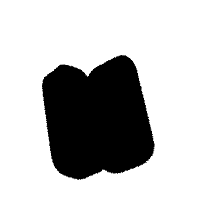


Predicted Images



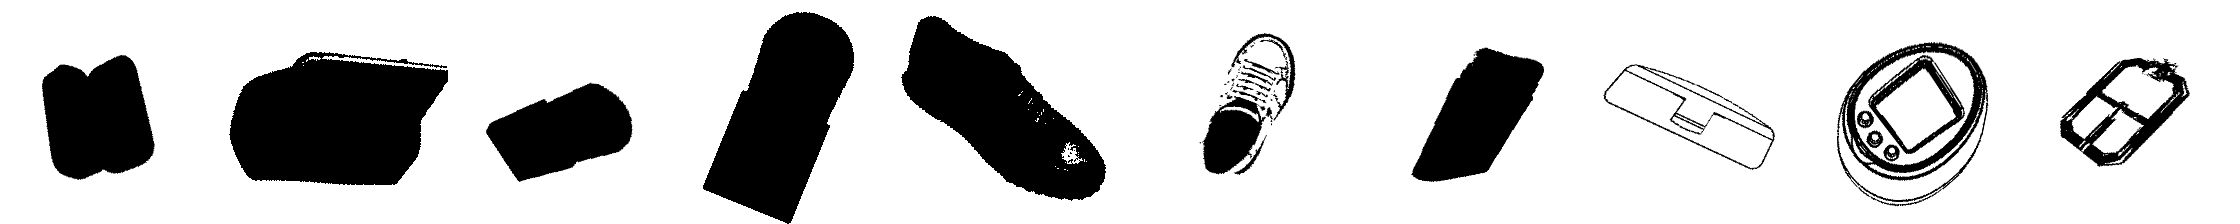

top3: True, top1: True, sim_score: 0.7237422466278076

Input Image


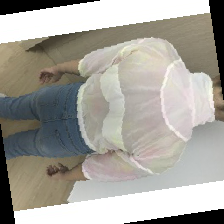


Positive Image



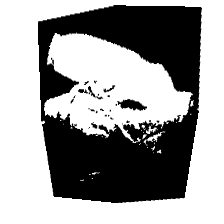


Predicted Images



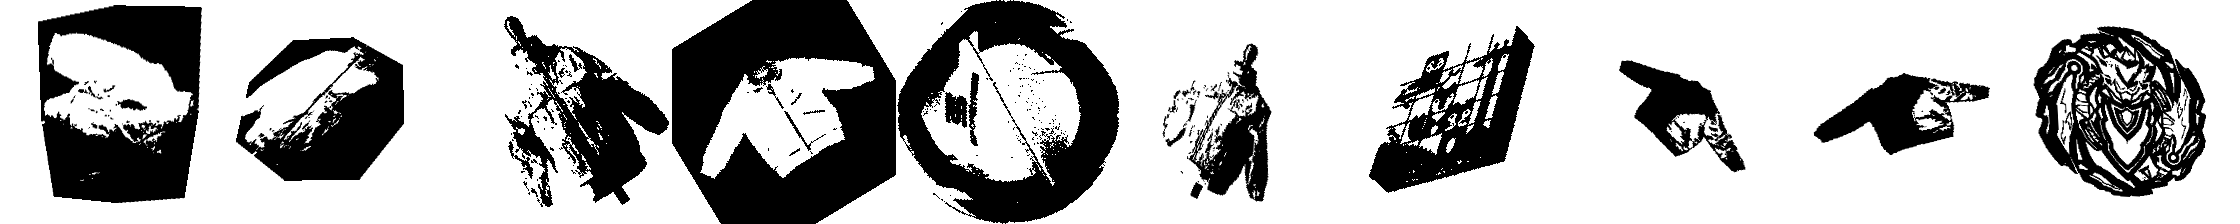

top3: True, top1: True, sim_score: 0.6334100365638733


In [4]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
# scores = results['s']
fms_ims_all = results['fms_ims_all']
fms_poss_all = results['fms_poss_all']
fms_negs_all = results['fms_negs_all']
ims = results['ims']
poss = results['poss']
classes_all = results['classes_all']
# negs = results['negs']

cnt = 0
    
for i, im in enumerate(ims):
    top3, top1 = 0, 0
    if i == 20:
        break
    print('\nInput Image')
    display(Image.fromarray((ims[i]*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)))
    print('\nPositive Image\n')
    display(Image.fromarray((poss[i]*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)))
    cnt += 1
    values, indices = torch.topk(cos(fms_ims_all[i], fms_poss_all), k=10)

    if classes_all[i] in classes_all[indices]:
        top3+=1
    if classes_all[i] in classes_all[indices[0]]:
        top1+=1
        
#     top3 = len(indices[i == indices])
#     top1 = len(indices[i == indices[0]])

    img_list = []
    img_list_gt = []
    for j in indices:
        img = (poss[j]*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)
        img_gt = (poss[i]*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)
        img_list.append(img)
        img_list_gt.append(img_gt)
    print('\nPredicted Images\n')
    display(Image.fromarray(np.concatenate(img_list, axis=1)))
#     print('\nGT sketch \n')
#     display(Image.fromarray(np.concatenate(img_list_gt, axis=1)))

    print(f"top3: {top3 == 1}, top1: {top1 == 1}, sim_score: {values[0].item()}")